In [33]:
from model.transformer import Transformer
import tensorflow as tf

In [3]:
from model_config import Config

train example size: 51785
evalution examples size: 1193


In [34]:
from data_process.dataset import tokenizer_en, tokenizer_pt
from model.multi_head_attention import create_mask

In [35]:
config = Config()

In [36]:
config.input_vocab_size, config.target_vocab_size

(8216, 8089)

In [37]:
transformer = Transformer(config.num_layers, config.d_model, config.num_heads, config.dff,
                          config.input_vocab_size, config.target_vocab_size, config.dropout_rate)

In [38]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer)

In [39]:
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored from: {}'.format(ckpt_manager.latest_checkpoint))

Latest checkpoint restored from: ./checkpoints/train/ckpt-2812


In [40]:
MAX_LENGTH = 40

def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_mask(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_en.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [41]:
import matplotlib.pyplot as plt 
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)

    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [42]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [43]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
Input: este é um problema que temos que resolver.
Predicted translation: 
Real translation: this is a problem we have to solve .


(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 11, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
(1, 8, 1, 1)
(1, 8, 1, 11)
Input: este é o primeiro livro que eu fiz.
Predicted translation: 


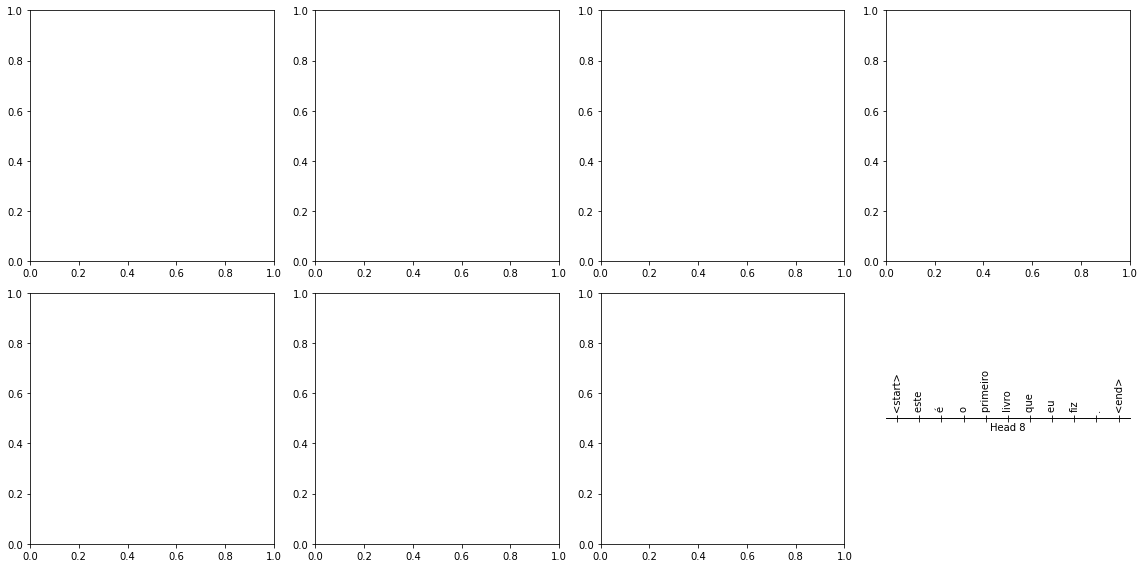

Real translation: this is the first book i've ever done.


In [44]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")